Tutorial for fitting with TiDEpy package
========================================

We are delighted that you have decided to use TiDEpy, the python wrapper for the TiDE software. In this small tutorial we show an example how one can use it to fit TDE candidates.

Install TiDEpy
--------------

First, you need to install TiDEpy package. For this, please follow the steps in the Getting Started tutorial.

Starting fitting procedure
-------------------------

During this tutorial, we will use the `curve_fit` method from `scipy` package.
First, import the packages.

In [1]:
import tidepy 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy import constants as const

DEBUG: backup to build directory in src.


Define the TiDEFit class
------------------------

Then we define the TiDEfit class. The fittable parameters are the following:
 - bh_M6: the mass of the black hole
 - star_mstar: the mass of the star
 - bh_eta: radiative efficiency of the black hole
 - fv: constant in the velocity of the wind
 - eta_r: the efficiency of the reprocessing
 - diffusion_timescale: the timescale of the diffusion

In this example the fout parameter is not fittable, as we use the TiDEpy default time dependent (built in) calculation method. 

In [2]:
class TiDEFit:
    """
    Lightcurve <- Parameters
    |-> lightcurve()
    -> diffuze()

    Parameters:
    M6,M_star,eta,fv,eta_r,t_d
    """
    def __init__(self,lc_type='simple',names=['bh_M6','star_mstar','bh_eta','fv','eta_r','diffusion_timescale']):
        self.p = tidepy.Parameters()
        self.lc = tidepy.Light_curve_of_tde(self.p)
        self.lc_calc = None
        if lc_type =='simple':
            self.lc_calc = self.lc.light_curve
        elif lc_type == 'diff':
            self.lc_calc = self.lc.diffused_light_curve
        else:
            raise ValueError('ctype should be either simple or diff')
        self.res = self.lc_calc()[0:2]
        self.indices=self.set_fit_indices(names)
    
    def set_fit_indices(self,names):
        print('DEBUG: names are:',names)
        self.indices=[]
        if 'bh_M6' in names:
            self.indices.append(0)
        if 'star_mstar' in names:
            self.indices.append(1)
        if 'bh_eta' in names:
            self.indices.append(2)
        if 'fv' in names:
            self.indices.append(3)
        if 'eta_r' in names:
            self.indices.append(4)
        if 'diffusion_timescale' in names:  
            self.indices.append(5)

        return self.indices


    def reset_model(self,params):
        oldparams = [
            self.p.bh_M6,
            self.p.star_mstar,
            self.p.bh_eta,
            self.p.fv,
            self.p.eta_r,
            self.p.diff_timescale
        ]
        new_params = list(oldparams)
        for i,index in enumerate(self.indices):
            new_params[index] = params[i]

        if np.any(oldparams != new_params):
            self.p.bh_M6 = new_params[0]
            self.p.star_mstar = new_params[1]
            self.p.bh_eta = new_params[2]
            self.p.fv = new_params[3]
            self.p.eta_r =new_params[4]
            self.p.diff_timescale = str(new_params[5])
            self.p.param_init()
            self.p.tstart_value += 1e-3
            self.res = self.lc_calc()


            

    def __call__(self,t,tini,*params):
        self.reset_model(params)
        if tini is not None:
            self.tini=tini
        t_cond=t-self.tini > self.p.tstart_value
        model_flux = np.zeros_like(t)
        model_flux[t_cond] = np.interp(t[t_cond]-self.tini, self.res[0], self.res[1])
        return model_flux

An example object: AT2019azh
----------------------------

For the next step we load the observed data of an example (AT2019azh). The observations were previously corrected for Milky Way extinction and redshift. The columns are the following:

 - Time
 - Observed wavelength (Angstrom)
 - Observed flux (erg/s)
 - Error of flux (erg/s)

64254.00844160755 m / (Angstrom s) 642540084416075.4


<ErrorbarContainer object of 3 artists>

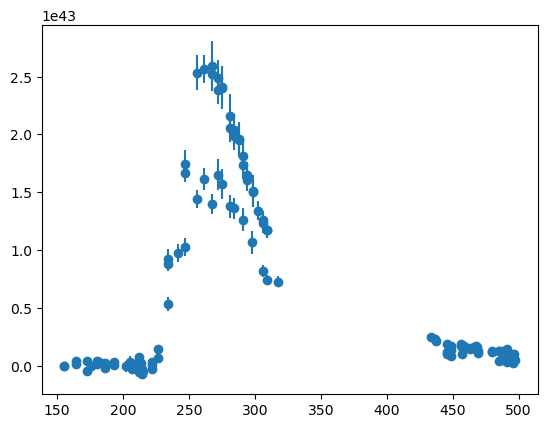

In [3]:
data = np.loadtxt('AT2019azh_datas.dat')
hjd=data[:,0]
frequency=(const.c/(data[:,1]*u.AA)).to(u.Hz).value
print(const.c/(data[0,1]*u.AA),frequency[0])
flux=data[:,2]
flux_err=data[:,3]
plt.errorbar(hjd, flux*frequency, yerr=flux_err*frequency, fmt='o')

Now select one observed band and the time range of the fit:

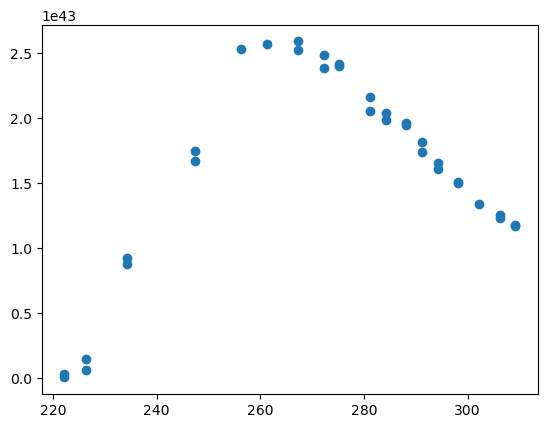

In [4]:
mask = (frequency == frequency[0]) & (hjd > 220.0) & (hjd < 360)

flux2 = flux[mask]
flux_err2 = flux_err[mask]
hjd2 = hjd[mask]
plt.plot(hjd2,flux2*frequency[0],'o')

Create one TiDEFit class, set the important parameters and the initial values:

DEBUG: names are: ['bh_M6', 'star_mstar', 'bh_eta', 'fv', 'eta_r', 'diffusion_timescale']
Parameters of the black hole:
	Mass: 3 10^6 M_sun	Schwarzschild radius: 8.84884e+09 m	R_ISCO: 2.65465e+10 m
Parameters of the star:
	Mass: 15 M_sun	radius: 3.87298 R_sun
	Used mass-radius relation: Main sequence
	Politrop: 5per3	n: 1.5
	K: 2.36787e+09	rho_c: 2175.38
Used time dependent fout
fv = 1.1	eta = 0.001	reprocessing eta = 0.1	beta = 1
d = 0	i = 0	nu = 6.4254e+14 Hz	N = 1000
Used classical tmin calculation with rt distance. tmin = 5.70016 day
tstart = 5.70016 day	tend = 118.653 day	dt = 0.5 day
rin = 2.65465e+10 m	rout = 3.15433e+11 m
Mdotfb calculated as L09.
Mdot_peak = 2.99557e+24 kg/s
tpeak = 15.1573
vwind = 1.4758e+07 m/s
DeltaOmega = 0.0202588 sr


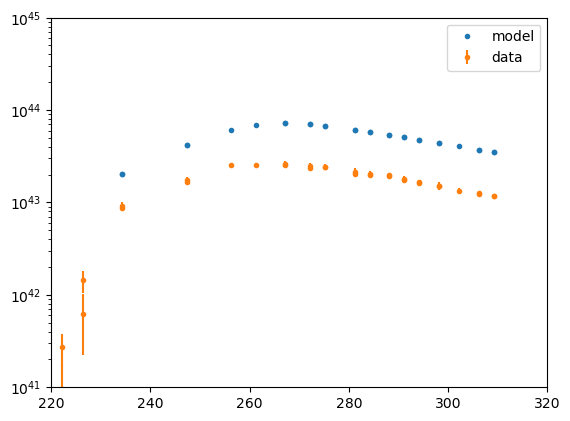

In [23]:
tfit=TiDEFit(lc_type='diff')
tfit.p.star_politrop = "5per3"
tfit.p.tend=hjd2[-1]-hjd2[0]+50
tfit.p.nu = frequency[0]

tfit.p.param_init()

p0 = [3.0, 15., 0.001, 1.1, 0.1, 20.0]
#plt.loglog()
plt.yscale('log')
plt.xlim(220,320)
plt.ylim(1e41,1e45)

plt.plot(hjd2,tfit(hjd2,220,*p0)*frequency[0],'.',label='model')
plt.errorbar(hjd2, flux2*frequency[0], yerr=flux_err2*frequency[0], fmt='.',label='data')
plt.legend()
tfit.p.print_params()

When using `curve_fit`, the parameters of the model light curve should be selected to produce a light curve close to the observations. Now we do the fit, write out the results and then plot them:

In [24]:
popt2,pcov2 = curve_fit(lambda x, t, *p: tfit(x,t,*p), hjd2, flux2, p0=[220,*p0],
                         sigma=flux_err2, bounds=([150,0.05,0.05,0.0001,1.0,0.,0.],[300.0,100.0,60.0,0.4,5.0,1.0,100]))

tini = 219.5835 +- 8.7196
bh_M6 = 3.1471 +- 29.2314
star_mstar = 23.8830 +- 355.9563
bh_eta = 0.0004 +- 0.0022
fv = 2.6403 +- 41.7038
eta_reprocessing = 0.0328 +- 0.1356
diffusion_timescale = 9.5545 +- 38.4302


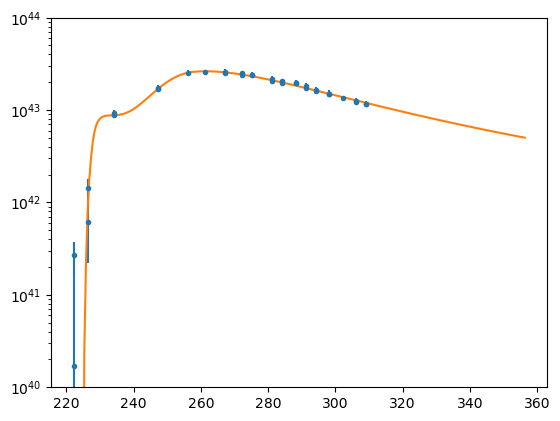

In [25]:
tfit.reset_model(popt2[1:])
plt.yscale('log')
plt.ylim(1e40,1e44)
plt.errorbar(hjd2, flux2*frequency[0], yerr=flux_err2*frequency[0], fmt='.')
plt.plot(tfit.res[0]+popt2[0],tfit.res[1]*frequency[0],'-')
names=['tini','bh_M6','star_mstar','bh_eta','fv', 'eta_reprocessing', 'diffusion_timescale']
for par,opt, cov in zip(names,popt2, np.sqrt(np.diag(pcov2))):
    print(f'{par} = {opt:.4f} +- {cov:.4f}')

As we can see, we have large errors in this example. This is usually an effect of too many free parameters, meanwhile there are non-linear correlations among the parameters. We can skip the reprocessing of the debris for insance ( it has a smaller impact), to get more conservative errors.

/home/kgabesz/miniconda3/envs/TiDE_run/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: divide by zero encountered in calc_lum_at_time (vectorized)
  outputs = ufunc(*inputs)
/home/kgabesz/miniconda3/envs/TiDE_run/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: overflow encountered in calc_lum_at_time (vectorized)
  outputs = ufunc(*inputs)
/home/kgabesz/miniconda3/envs/TiDE_run/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in calc_lum_at_time (vectorized)
  outputs = ufunc(*inputs)


DEBUG: names are: ['bh_M6', 'star_mstar', 'bh_eta', 'fv', 'diffusion_timescale']
Parameters of the black hole:
	Mass: 3 10^6 M_sun	Schwarzschild radius: 8.84884e+09 m	R_ISCO: 2.65465e+10 m
Parameters of the star:
	Mass: 15 M_sun	radius: 3.87298 R_sun
	Used mass-radius relation: Main sequence
	Politrop: 5per3	n: 1.5
	K: 2.36787e+09	rho_c: 2175.38
Used time dependent fout
fv = 1.1	eta = 0.001	reprocessing eta = 0	beta = 1
d = 0	i = 0	nu = 6.4254e+14 Hz	N = 1000
Used classical tmin calculation with rt distance. tmin = 5.70016 day
tstart = 5.70016 day	tend = 118.653 day	dt = 0.5 day
rin = 2.65465e+10 m	rout = 3.15433e+11 m
Mdotfb calculated as L09.
Mdot_peak = 2.99557e+24 kg/s
tpeak = 15.1573
vwind = 1.4758e+07 m/s
DeltaOmega = 0.0202588 sr


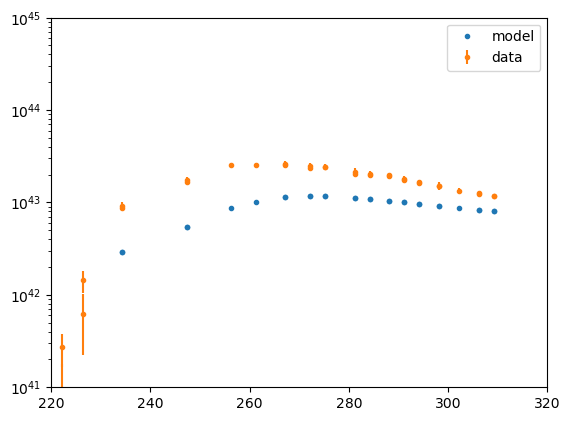

In [27]:
tfit2=TiDEFit(lc_type='diff', names=['bh_M6','star_mstar','bh_eta','fv','diffusion_timescale'])
tfit2.p.star_politrop = "5per3"
tfit2.p.tend=hjd2[-1]-hjd2[0]+50
tfit2.p.nu = frequency[0]

tfit2.p.param_init()

p0 = [3.0, 15., 0.001, 1.1, 20.0]
#plt.loglog()
plt.yscale('log')
plt.xlim(220,320)
plt.ylim(1e41,1e45)

plt.plot(hjd2,tfit2(hjd2,220,*p0)*frequency[0],'.',label='model')
plt.errorbar(hjd2, flux2*frequency[0], yerr=flux_err2*frequency[0], fmt='.',label='data')
plt.legend()
tfit2.p.print_params()

In [28]:
popt2,pcov2 = curve_fit(lambda x, t, *p: tfit2(x,t,*p), hjd2, flux2, p0=[220,*p0],
                         sigma=flux_err2, bounds=([150,0.05,0.05,0.0001,1.0,0.],[300.0,100.0,60.0,0.4,5.0,100]))

/home/kgabesz/miniconda3/envs/TiDE_run/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: divide by zero encountered in calc_lum_at_time (vectorized)
  outputs = ufunc(*inputs)


tini = 217.4129 +- 0.6151
bh_M6 = 3.3932 +- 1.4203
star_mstar = 13.7029 +- 7.8549
bh_eta = 0.0015 +- 0.0002
fv = 1.0000 +- 0.6411
diffusion_timescale = 20.7034 +- 3.1594


/home/kgabesz/miniconda3/envs/TiDE_run/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: divide by zero encountered in calc_lum_at_time (vectorized)
  outputs = ufunc(*inputs)


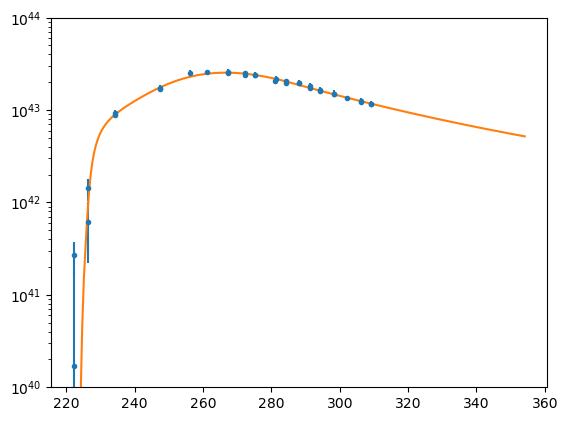

In [30]:
tfit2.reset_model(popt2[1:])
plt.yscale('log')
plt.ylim(1e40,1e44)
plt.errorbar(hjd2, flux2*frequency[0], yerr=flux_err2*frequency[0], fmt='.')
plt.plot(tfit2.res[0]+popt2[0],tfit2.res[1]*frequency[0],'-')
names=['tini','bh_M6','star_mstar','bh_eta','fv', 'diffusion_timescale']
for par,opt, cov in zip(names,popt2, np.sqrt(np.diag(pcov2))):
    print(f'{par} = {opt:.4f} +- {cov:.4f}')

As we can see, now we have more conservative errors on the paramereters, while the light curve doesn't show that strange bump in the begining.

### Usage with other algorithms

In principle the previous example (the `TiDEFit` class) would work with any fitting algorithm that needs a callable function in the

```python
def function(x, *args)
```

form. But be aware that TiDEpy is generally a wrapper above the C++ TiDE program. This means, that in the background a single model object is created and manipulated. Therefore, concurrent calls of the `TiDEfit.__call__` function would cause race conditions. If one wants to do a fit with multiple concurrent threads (typical for MCMC), they must ensure that every thread has a designated `TiDEfit` object. 

### Calculation overhead

Be aware that diffused light curves are calculated using the integrated light curve before the given time points. Although the above implementation is optimized, so light curve generation is done per parameter changes, (and we interpolate in time), if in your favourite algorithm the x running variable is not the one that is changing the fastest, be prepared for heavy overheads.